## `Target`
1. Will be adding GAP layer and increase the heaviness of the model
2. Apply augmentation techniques
4. Tried to make bias false during the convolutions
5. Also i noticed keeping 2 max pools ir reducing the accuracies and it cant reach even 99.2 consistently therfore will to reduce it and add more convolution layer
6. Also noticed that you didnt add BatchNorm and dropout after the convoulution with kernel size 1, will try to do it and see results
7. Also will try to reduce the number of convolution blocks(as in the lecture) and see the results.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets, transforms

In [5]:
train_transforms = transforms.Compose([transforms.RandomRotation((-7.0,7.0), fill = (1,)) ,  
                                      transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081, ))])


In [6]:
train = datasets.MNIST('./data', train = True, download = True, transform = train_transforms)
test = datasets.MNIST('./data', train = False, download = True, transform = test_transforms)

In [7]:
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA available" , cuda)

#for Reproducibilty
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# setting the dataloader arguments for both test and train data
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4, pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)

train_loader = torch.utils.data.DataLoader(train , **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


CUDA available True


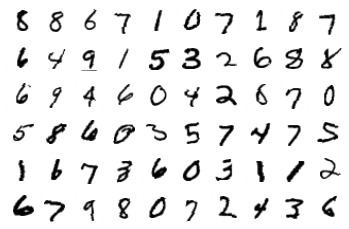

In [8]:
images,labels = next(iter(train_loader))
import numpy as np
import matplotlib.pyplot as plt

num_of_images = 60
for index in range(1, num_of_images + 1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap = 'gray_r')

# print(labels)

In [62]:
dropout_value = 0.07
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    ## INPUT BLOCK (BLOCK  1 )
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = (3,3), bias = False),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(dropout_value)   
    )# input - 28, output - 26
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 1, bias = False),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(dropout_value)
    )#input - 26 , output - 26
    

    # TRANSITION BLOCK 
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = (1,1), bias = False),
        # nn.BatchNorm2d(10),
        # nn.ReLU(),
        # nn.Dropout(dropout_value)
    )# input - 26 , output - 26
    self.pool1 = nn.MaxPool2d(2, 2)
    # input 26, output - 13

    # CONVOLUTION  BLOCK 2
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 16 , kernel_size = (3,3), bias = False),
        nn.BatchNorm2d(16),
        nn.ReLU(),#input = 13 , output  = 11
        nn.Dropout(dropout_value)
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 1, bias = False),
        nn.BatchNorm2d(16),
        nn.ReLU(),# input - 11 , output = 11
        nn.Dropout(dropout_value)
    )

    #   TRANSITION BLOCK 
    self.conv6 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = (1,1), bias = False),
        # nn.BatchNorm2d(10),
        # nn.ReLU(), # input - 11, output - 11
        # nn.Dropout(dropout_value)
    )
    # # self.pool2 = nn.MaxPool2d(2,2) #input 12, output 6

    # #   CONVOLUTION BLOCK 3

    self.conv7 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 8 , kernel_size = (3,3),bias = False),
        nn.BatchNorm2d(8),
        nn.ReLU(),#input = 11, output = 9
        nn.Dropout(dropout_value)
    )
    self.conv8 = nn.Sequential(
        nn.Conv2d(in_channels= 8, out_channels = 16, kernel_size = (3,3), bias = False),
        nn.BatchNorm2d(16),
        nn.ReLU(),#input = 9, output = 7
        nn.Dropout(dropout_value)
    )
    self.conv9 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), bias = False),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(dropout_value) 
    )#input - 7 , output - 5 


    #      CONVOLUTION BLOCK 4
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size = 5)
    )# output 1
    self.conv10 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 10, kernel_size = (1,1), bias = False)
    )
    


  def forward(self, x ):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.pool1(x)

    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)

    x = self.conv7(x)
    x = self.conv8(x)

    x = self.conv9(x)

    x = self.gap(x)

    x = self.conv10(x)


    x = x.view(-1,10)
    return F.log_softmax(x, dim = -1)


In [63]:

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size = (1,28,28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 26, 26]           2,304
       BatchNorm2d-6           [-1, 16, 26, 26]              32
              ReLU-7           [-1, 16, 26, 26]               0
           Dropout-8           [-1, 16, 26, 26]               0
            Conv2d-9            [-1, 8, 26, 26]             128
        MaxPool2d-10            [-1, 8, 13, 13]               0
           Conv2d-11           [-1, 16, 11, 11]           1,152
      BatchNorm2d-12           [-1, 16, 11, 11]              32

In [64]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimiser, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    #get samples
    data, target = data.to(device), target.to(device)

    #init
    optimiser.zero_grad()

    #prediction
    y_pred = model(data)

    #calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    #Backpropagation
    loss.backward()
    optimiser.step()

    # update pbar - tqdm

    pred = y_pred.argmax(dim = 1, keepdim = True) # gets the index of the max log-probabilirty
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  
  test_acc.append(100. * correct / len(test_loader.dataset))


In [65]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.22045810520648956 Batch_id=468 Accuracy=81.80: 100%|██████████| 469/469 [00:24<00:00, 19.52it/s]



Test set: Average loss: 0.0957, Accuracy: 9721/10000 (97.21%)

EPOCH: 1


Loss=0.03583424538373947 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]



Test set: Average loss: 0.0482, Accuracy: 9869/10000 (98.69%)

EPOCH: 2


Loss=0.052883077412843704 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:19<00:00, 24.06it/s]



Test set: Average loss: 0.0379, Accuracy: 9874/10000 (98.74%)

EPOCH: 3


Loss=0.028870798647403717 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s]



Test set: Average loss: 0.0351, Accuracy: 9883/10000 (98.83%)

EPOCH: 4


Loss=0.0675908550620079 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:19<00:00, 23.95it/s]



Test set: Average loss: 0.0350, Accuracy: 9886/10000 (98.86%)

EPOCH: 5


Loss=0.03955832123756409 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]



Test set: Average loss: 0.0308, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Loss=0.048263002187013626 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]



Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.30%)

EPOCH: 7


Loss=0.013590446673333645 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:19<00:00, 23.75it/s]



Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.02515847235918045 Batch_id=59 Accuracy=98.74:  13%|█▎        | 60/469 [00:02<00:17, 23.27it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6d742dce50>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f6d742dce50>  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

    Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6d742dce50>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/lib/python3.8/multiprocessing/process.p


Test set: Average loss: 0.0235, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.08146004378795624 Batch_id=43 Accuracy=98.56:   9%|▉         | 43/469 [00:02<00:16, 25.41it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6d742dce50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6d742dce50>

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
      File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdo


Test set: Average loss: 0.0222, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


Loss=0.009602713398635387 Batch_id=14 Accuracy=99.17:   3%|▎         | 14/469 [00:00<00:23, 19.49it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6d742dce50>Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f6d742dce50>Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f6d742dce50>  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
self._shutdown_workers()

    Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
self._shutdown_workers()        self._shutdown_workers()
if w.is_alive()


Test set: Average loss: 0.0250, Accuracy: 9915/10000 (99.15%)

EPOCH: 11


Loss=0.014662424102425575 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:21,  3.30it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6d742dce50><function _MultiProcessingDataLoaderIter.__del__ at 0x7f6d742dce50>

Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6d742dce50>Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

    self._shutdown_workers()  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f6d742dce50>  File 


Test set: Average loss: 0.0228, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.07122963666915894 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:19<00:00, 23.92it/s]



Test set: Average loss: 0.0231, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.06272076070308685 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:19<00:00, 24.02it/s]



Test set: Average loss: 0.0178, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.028698936104774475 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:19<00:00, 23.77it/s]



Test set: Average loss: 0.0189, Accuracy: 9945/10000 (99.45%)

EPOCH: 15


Loss=0.026847153902053833 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:19<00:00, 23.84it/s]



Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

EPOCH: 16


Loss=0.11522406339645386 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:19<00:00, 23.89it/s]



Test set: Average loss: 0.0197, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.017143940553069115 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:20<00:00, 22.67it/s]



Test set: Average loss: 0.0173, Accuracy: 9946/10000 (99.46%)

EPOCH: 18


Loss=0.004129932262003422 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]



Test set: Average loss: 0.0189, Accuracy: 9948/10000 (99.48%)

EPOCH: 19


Loss=0.017675599083304405 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:20<00:00, 23.42it/s]



Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)




Results:
1. Parameters: 10.5k
2. Best Test Accuracy: 99.45(in 15 epochs)
3. Best Train Accuracy: 98.96

Conclusion:
1. Model is good, no overfitting and achieved around the target percentage in last 3 of 15 epochs without even implementing StepLR
2. Added GAP layer and increased the convolution layers in the end
3. Making bias False didnt make much of a difference
4. Removing the 2nd Maxpool and adding some convolution layers in that place increased both the accuracies
5. Also tried adding batchnorm and dropout for the transition layers whihch made the model worse so removed it.
6. Tried to reduce the layers as in lecture there were just 6 and increasing the channel size but it didnt gave results therefor added more layers and decreased the channel size a bit which proved to be a bit better.
7. AT LAST, i will try StepLR next and will try to reduce some parametres to bring it under 10k, which i know should have been done earlier.


